In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Pre-Processing

In [155]:
netflix = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/netflix_final_data.csv')
ratings = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/title.ratings.tsv', sep='\t')
basics = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])

/var/folders/cl/5v9cpvt93sjd32_z1w8t6b0c0000gn/T/ipykernel_31265/1367458723.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


### Merging and Cleaning Further

In [156]:
df = netflix.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst', )

In [157]:
#My Wonderful Life Manually added data

df.loc[df['title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

### Change isTop10 Column into Integers and Replace \\N into NaN

In [158]:
df['is_top10'] = df['is_top10'].astype(int)
df.replace('\\N', np.nan, inplace=True)

### Split into Movies and Shows

In [159]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## MOVIES
### LOGISTIC REGRESSION

### Drop Columns that aren't Needed

In [160]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'combined_title', 'title', 'season', 'is_tv_show', 'isAdult'], axis = 1)

In [161]:
movies

,release_year_x,is_top10,averageRating,numVotes,titleType,runtimeMinutes,genres
2,2020,0,6.1,856.0,movie,100,"Comedy,Family"
4,2021,1,5.8,1531.0,movie,102,"Comedy,Romance"
5,2022,1,6.9,1928.0,movie,92,Documentary
7,2021,1,6.3,932.0,movie,104,"Crime,Documentary"
8,2022,0,5.2,621.0,movie,91,"Comedy,Drama,Family"
...,...,...,...,...,...,...,...
2219,2021,1,6.7,925.0,movie,102,"Biography,Drama,Sport"
2221,2020,0,6.3,2648.0,movie,97,"Documentary,Music"
2222,2022,1,8.0,9043.0,tvMiniSeries,90,"Documentary,Music"
2224,2021,1,7.5,103877.0,movie,120,"Biography,Drama,Musical"


In [162]:
from sklearn.model_selection import train_test_split
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=100)

# Training set
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

# Test set
movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

In [163]:
# remove any rows with NaN genres and titleType because those won't be handled by the transformer
# training set removal
indexRowsToRemove_train = movies_train_X[(movies_train_X.genres.isna()) & (movies_train_X.titleType.isna())].index
movies_train_X.drop(index = indexRowsToRemove_train[0], axis = 1, inplace = True)
movies_train_Y.drop(index = indexRowsToRemove_train[0], axis = 1, inplace = True)

# test set removal
indexRowsToRemove_test = movies_test_X[(movies_test_X.genres.isna()) & (movies_test_X.titleType.isna())].index
movies_test_X.drop(index = indexRowsToRemove_test[0], axis = 1, inplace = True)
movies_test_Y.drop(index = indexRowsToRemove_test[0], axis = 1, inplace = True)

In [164]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [165]:
movies_test_X.isna().sum()

release_year_x     0
averageRating      3
numVotes           3
titleType          0
runtimeMinutes    13
genres             0
dtype: int64

In [166]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model
pipeLogReg = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))      # Build logistic Regression model
        
    ]
)    

In [168]:
# use grid search to cross validate logistic regression model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    pipeLogReg,
    param_grid={
        'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
        'logistic_regress__solver': ['lbfgs','saga'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [169]:
gs.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [170]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gs.best_params_
gs.best_score_
best_logistic = gs.best_estimator_

In [171]:
best_logistic

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['titleType']),
                                                 ('imputer', SimpleImputer(),
                                                  ['averageRating', 'numVotes',
                                                   'runtimeMinutes']),
                                                 ('bagofw', CountVectorizer(),
                                                  'genres')])),
                ('normalizer', Normalizer()),
                ('standardizer', StandardScaler(with_mean=False)),
                ('logistic_regress',
                 LogisticRegression(C=0.01, max_iter=1000))])

Accuracy:  0.6636363636363637
AUC:  0.7308075772681953


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


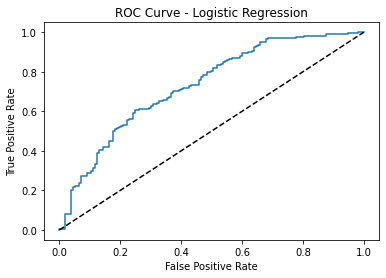

In [172]:
# fit best logistic regression model on movies and compute metrics
best_logistic.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_logistic.predict_proba(movies_test_X)[:,1]
y_pred = best_logistic.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

AUCPR:  0.7181797888832473


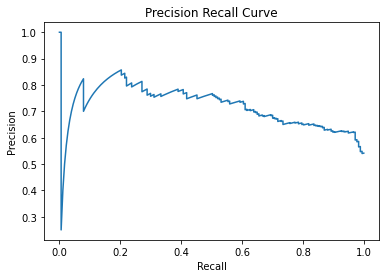

F1 Score:  0.7189873417721518


In [173]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

In [174]:
# determine feature importance for logistic regression model - movies
ohe_cols = gs.best_estimator_.named_steps['transformer'].transformers_[0][1].get_feature_names_out()
imputer_cols = gs.best_estimator_.named_steps['transformer'].transformers_[1][2]
bagofw_cols = [f"genre_{i}" for i in gs.best_estimator_.named_steps['transformer'].transformers_[2][1].get_feature_names_out()]
remaining_cols = ['release_year_x']

feature_names = np.concatenate((ohe_cols, imputer_cols, bagofw_cols, remaining_cols))
feature_names


array(['titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
       'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort',
       'titleType_tvSpecial', 'averageRating', 'numVotes',
       'runtimeMinutes', 'genre_action', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_fi', 'genre_game', 'genre_history',
       'genre_horror', 'genre_music', 'genre_musical', 'genre_mystery',
       'genre_news', 'genre_reality', 'genre_romance', 'genre_sci',
       'genre_short', 'genre_show', 'genre_sport', 'genre_talk',
       'genre_thriller', 'genre_tv', 'genre_war', 'genre_western',
       'release_year_x'], dtype=object)

In [175]:
#create dataframe of coefficients
coef_df = pd.DataFrame(
    data=best_logistic.named_steps['logistic_regress'].coef_.T,
    index=feature_names,
    columns=['coef']
)
coef_df.sort_values(by='coef', ascending=False)

,coef
titleType_tvSeries,0.188301
numVotes,0.173953
genre_adventure,0.120725
genre_family,0.099095
genre_biography,0.094699
genre_crime,0.078977
genre_talk,0.065239
genre_western,0.051877
titleType_tvMiniSeries,0.050735
genre_action,0.030908


### DECISION TREE (CART)

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model (CART)
pipeDecTree = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

In [177]:
# use grid search to cross validate decision tree model - 5-fold cross validation

gsDT = GridSearchCV(
    pipeDecTree,
    param_grid={
        'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
        'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20],
        'decisiontree__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [178]:
gsDT.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [179]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsDT.best_params_
gsDT.best_score_
best_decisiontree = gsDT.best_estimator_

Accuracy:  0.693939393939394
AUC:  0.7338539935748312


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


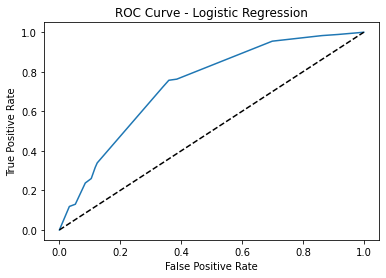

In [180]:
best_decisiontree.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_decisiontree.predict_proba(movies_test_X)[:,1]
y_pred = best_decisiontree.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

AUCPR:  0.7354770875440632


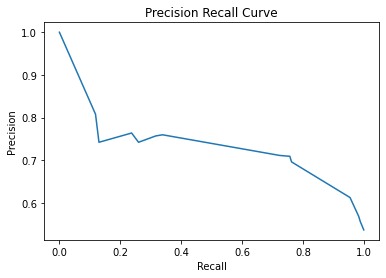

F1 Score:  0.7170868347338935


In [181]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

## TV SERIES
### LOGISTIC REGRESSION

In [182]:
# drop columns that are not needed
tv_shows = tv_shows.drop(['tconst', 'combined_title', 'title', 'is_tv_show', 'isAdult'], axis = 1)

In [183]:
tv_shows

,release_year_x,is_top10,season,averageRating,numVotes,titleType,runtimeMinutes,genres
0,2020,0,1,6.8,4892.0,tvSeries,36,Comedy
1,2020,0,1,6.4,1091.0,tvSeries,NaN,Documentary
3,2020,0,1,5.8,4153.0,tvSeries,NaN,Reality-TV
6,2020,1,4,7.5,289852.0,tvSeries,60,"Drama,Mystery,Thriller"
11,2020,1,4,7.3,25736.0,tvSeries,49,"Action,Drama,Sci-Fi"
...,...,...,...,...,...,...,...,...
2216,2022,0,1,5.6,242.0,tvSeries,35,"Comedy,Fantasy"
2218,2021,1,1,5.7,1462.0,tvSeries,35,"Comedy,Drama,Family"
2220,2021,0,1,5.7,1329.0,tvSeries,27,"Action,Comedy,Drama"
2223,2020,0,1,2.5,3352.0,tvSeries,30,"Documentary,Reality-TV"


In [184]:
from sklearn.model_selection import train_test_split
tvShows_train, tvShows_test = train_test_split(tv_shows, test_size=0.3, random_state=100)

# Training set
tvShows_train_X = tvShows_train.drop(['is_top10'], axis = 1)
tvShows_train_Y = tvShows_train['is_top10']

# Test set
tvShows_test_X = tvShows_test.drop(['is_top10'], axis = 1)
tvShows_test_Y = tvShows_test['is_top10']

In [185]:
# remove any rows with NaN seasons because those won't be handled by the transformer
# training set removal
indexRowsToRemove_train = tvShows_train_X[tvShows_train_X.season.isna()].index
tvShows_train_X.drop(index = list(indexRowsToRemove_train.values), axis = 1, inplace = True)
tvShows_train_Y.drop(index = list(indexRowsToRemove_train.values), axis = 1, inplace = True)

# # test set removal
indexRowsToRemove_test = tvShows_test_X[(tvShows_test_X.genres.isna()) | (tvShows_test_X.season.isna())].index
tvShows_test_X.drop(index = list(indexRowsToRemove_test.values), axis = 1, inplace = True)
tvShows_test_Y.drop(index = list(indexRowsToRemove_test.values), axis = 1, inplace = True)

In [186]:
# clean seasons column of tvShows_train_X (some seasons have bits coming after the number)
import re
tvShows_train_X['season'] = [int((re.findall(r'\d+', i)[0])) for i in tvShows_train_X.season]
tvShows_test_X['season'] = [int((re.findall(r'\d+', i)[0])) for i in tvShows_test_X.season]

In [187]:
tvShows_test_X.isna().sum()

release_year_x     0
season             0
averageRating      2
numVotes           2
titleType          0
runtimeMinutes    75
genres             0
dtype: int64

In [188]:
tvShows_train_X.isna().sum()

release_year_x      0
season              0
averageRating       6
numVotes            6
titleType           0
runtimeMinutes    173
genres              0
dtype: int64

In [189]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

In [190]:
# use grid search to cross validate logistic regression model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

# make sklearn pipeline with transform, normalization, and model
pipeLogReg = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))      # Build logistic Regression model
        
    ]
)    

gsLR_tvShows = GridSearchCV(
    pipeLogReg,
    param_grid={
        'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
        'logistic_regress__solver': ['lbfgs','saga'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [191]:
gsLR_tvShows.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached wh

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [192]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsLR_tvShows.best_params_
gsLR_tvShows.best_score_
best_lr_tvshows = gsLR_tvShows.best_estimator_

In [207]:
ohe_cols = gsLR_tvShows.best_estimator_.named_steps['transformer'].transformers_[0][1].get_feature_names_out()
imputer_cols = gsLR_tvShows.best_estimator_.named_steps['transformer'].transformers_[1][2]
bagofw_cols = [f"genre_{i}" for i in gsLR_tvShows.best_estimator_.named_steps['transformer'].transformers_[2][1].get_feature_names_out()]
remaining_cols = ['release_year_x', 'season']

feature_names = np.concatenate((ohe_cols, imputer_cols, bagofw_cols, remaining_cols))


In [206]:
#create dataframe of coefficients
coef_df = pd.DataFrame(
    data=best_lr_tvshows.named_steps['logistic_regress'].coef_.T,
    index=feature_names,
    columns=['coef']
)
coef_df.sort_values(by='coef', ascending=False)

,coef
numVotes,0.442382
genre_drama,0.148037
genre_fantasy,0.116420
genre_crime,0.084353
genre_romance,0.076418
genre_action,0.075638
genre_family,0.074486
genre_mystery,0.066494
genre_war,0.054062
titleType_tvEpisode,0.038447


Accuracy:  0.7321428571428571
AUC:  0.7188679245283018


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


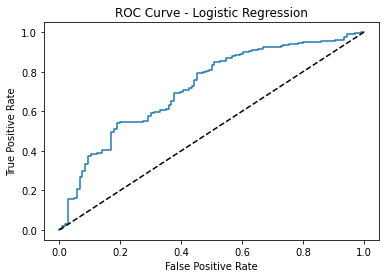

In [195]:
best_lr_tvshows.fit(tvShows_train_X, tvShows_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_lr_tvshows.predict_proba(tvShows_test_X)[:,1]
y_pred = best_lr_tvshows.predict(tvShows_test_X)

print("Accuracy: ", accuracy_score(tvShows_test_Y, y_pred))
print("AUC: ", roc_auc_score(tvShows_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(tvShows_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

AUCPR:  0.8224358991111455


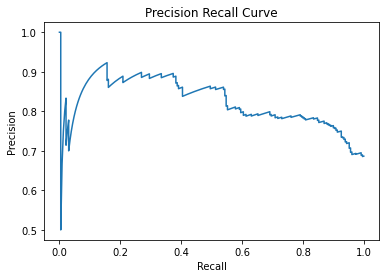

F1 Score:  0.8235294117647057


In [196]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(tvShows_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))

### DECISION TREE

In [197]:
# use grid search to cross validate logistic regression model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model (CART)
pipeDecTree = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

# use grid search to cross validate decision tree model - 5-fold cross validation
gsDT_tvShows = GridSearchCV(
    pipeDecTree,
    param_grid={
        'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
        'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20],
        'decisiontree__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [198]:
gsDT_tvShows.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [199]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsDT_tvShows.best_params_
gsDT_tvShows.best_score_
best_dt_tvshows = gsDT_tvShows.best_estimator_

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy:  0.7291666666666666
AUC:  0.6970877768662838


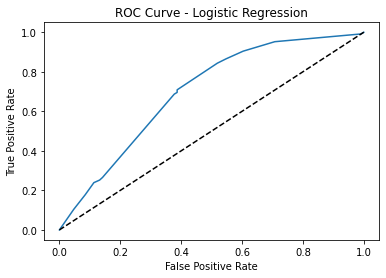

In [200]:
best_dt_tvshows.fit(tvShows_train_X, tvShows_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_dt_tvshows.predict_proba(tvShows_test_X)[:,1]
y_pred = best_dt_tvshows.predict(tvShows_test_X)

print("Accuracy: ", accuracy_score(tvShows_test_Y, y_pred))
print("AUC: ", roc_auc_score(tvShows_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(tvShows_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

AUCPR:  0.8054927101446638


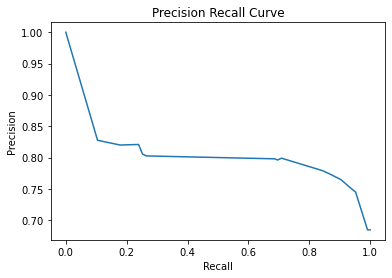

F1 Score:  0.8100208768267224


In [201]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(tvShows_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))

In [202]:
gsDT_tvShows.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['titleType']),
                                                 ('imputer', SimpleImputer(),
                                                  ['averageRating', 'numVotes',
                                                   'runtimeMinutes']),
                                                 ('bagofw', CountVectorizer(),
                                                  'genres')])),
                ('normalizer', Normalizer()),
                ('standardizer', StandardScaler(with_mean=False)),
                ('decisiontree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                      